In [1]:
from statsmodels.imputation import mice
from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd
import seaborn as sns

# Visualizing Missing Data


In [2]:
available_data = pd.read_csv(r'/home/beastman/Projects/HomeSchool/data-analysis/BehavioralDataAnalysis/Chapter 6 - Handling missing data/chap6-available_data.csv')

In [3]:
from itertools import combinations

# building a 4-axis function equivalent to the R function
# top: columns sorted by number of missing values
# bottom: total missing value counts per column
# left: count of non-null rows across combinations of variables
# right: count of combinations of columns with null values (unnecessary)
def md_pattern(df: pd.DataFrame):
    null_counts = df.isna().sum().sort_values()
    null_list = null_counts[null_counts.values > 0].keys()

    viz = pd.DataFrame(columns = list(null_counts.keys())+ ["null count", "depth","col_nulls"])

    r1b = pd.Series(data = dict.fromkeys(list(null_counts.keys()), " ")).to_frame().T
    r1b["null count"] = len(df.dropna())
    r1b["depth"] = len(null_list)
    r1b["col_nulls"] = 0

    viz = pd.concat([viz, r1b])

    for a in range(1,len(null_list) + 1):
        comb = [list(x) for x in combinations(null_list, a)]

        for c in comb:
            bool_null = dict.fromkeys(list(null_counts.keys()), " ")
            depth = list(null_list).index(c[0])
            search_list = c
            include =  list()
            exclude = list()

            for i, x in enumerate(search_list):
                
                index_list = list(df[df[x].isnull()].index)
                if i == 0:
                    include = index_list
                else:
                    for item in include[::-1]:
                        if item not in index_list:
                            include.remove(item)                

            for y in df.columns.drop(search_list):
                exclude += list(df[df[y].isnull()].index)

            null_count = len(df[(df.index.isin(include)) & ~(df.index.isin(exclude))])

            if null_count > 0:
                for col in c:
                    bool_null[col] = "X"
                
                col_nulls = sum("X" == x for x in list(bool_null.values()))
                bool_null["col_nulls"] = col_nulls
                bool_null["null count"] = null_count
                bool_null["depth"] = depth
                

                row = pd.Series(data = bool_null).to_frame().T

                viz = pd.concat([viz, row], ignore_index=True)
            else: 
                break

    vizdf = (viz.set_index("depth")).sort_values(by=["depth"], ascending=[False]).reset_index(drop=True)
    return vizdf, null_counts

viz, counts = md_pattern(available_data)

viz

,age,open,gender,bkg_amt,state,extra,neuro,null count,col_nulls
0,,,,,,,,368,0
1,,,,,,,X,358,1
2,,,,,,X,,249,1
3,,,,,,X,X,228,2
4,,,,,X,,,163,1
5,,,,,X,X,,125,2
6,,,,,X,,X,214,2
7,,,,,X,X,X,120,3
8,,,,X,,,,33,1
9,,,,X,X,,,24,2


In [4]:
counts

age           0
open          0
gender        0
bkg_amt     175
state       711
extra       793
neuro      1000
dtype: int64

In [5]:
min_data_df = available_data.copy()
min_data_df.neuro = np.where(min_data_df.neuro.isna(), min_data_df.neuro.min(), min_data_df.neuro)

max_data_df = available_data.copy()
max_data_df.neuro = np.where(max_data_df.neuro.isna(), max_data_df.neuro.max(), max_data_df.neuro)


for data in [available_data, min_data_df, max_data_df]:
    print(ols("bkg_amt~neuro", data=data).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                bkg_amt   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     7.492
Date:                Mon, 30 Oct 2023   Prob (F-statistic):            0.00632
Time:                        14:28:10   Log-Likelihood:                -5187.4
No. Observations:                 905   AIC:                         1.038e+04
Df Residuals:                     903   BIC:                         1.039e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    258.0886     14.306     18.041      0.0

## Correlation of Missingneess

<Axes: >

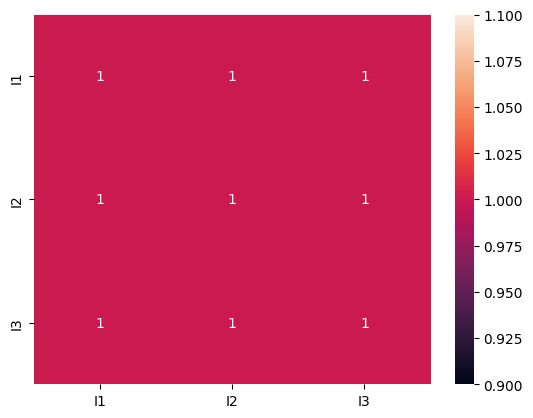

In [6]:
tampa = pd.read_csv(r'/home/beastman/Projects/HomeSchool/data-analysis/BehavioralDataAnalysis/Chapter 6 - Handling missing data/chap6-tampa.csv')
tacoma = pd.read_csv(r'/home/beastman/Projects/HomeSchool/data-analysis/BehavioralDataAnalysis/Chapter 6 - Handling missing data/chap6-tacoma.csv')

tampa_missing = tampa.copy().drop(['ID'], axis=1).isna()
tacoma_missing = tacoma.copy().drop(['ID'], axis=1).isna()

tampa_cor = tampa_missing.corr()
tacoma_cor = tacoma_missing.corr()

sns.heatmap(tampa_cor, annot=True)

<Axes: >

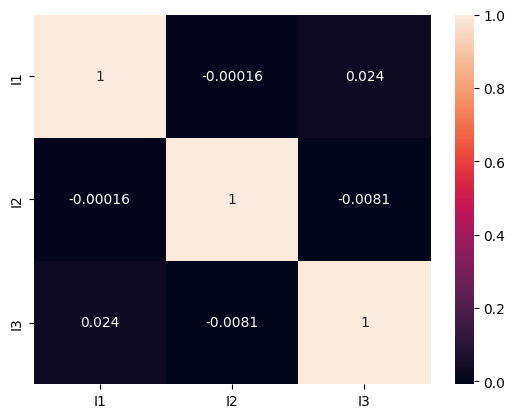

In [7]:
sns.heatmap(tacoma_cor, annot=True)

<Axes: >

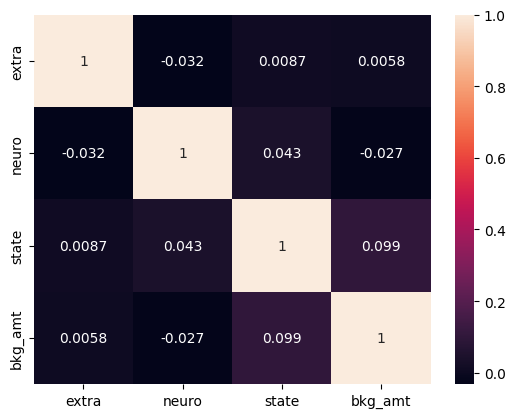

In [8]:
available_data_missing = available_data.copy().drop(['age','open','gender'],axis=1).isna().corr()

sns.heatmap(available_data_missing, annot=True)

missing values are almost entirely uncorrelated or apparently MCAR.

## Diagnosing MCAR Variables

In [9]:
available_data['md_extra'] = available_data['extra'].isnull().astype(float)
md_extra_mod = smf.logit('md_extra~age+open+neuro+gender+state+bkg_amt', data=available_data)
md_extra_mod.fit().summary()

Optimization terminated successfully.
         Current function value: 0.672086
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               md_extra   No. Observations:                  617
Model:                          Logit   Df Residuals:                      609
Method:                           MLE   Df Model:                            7
Date:                Mon, 30 Oct 2023   Pseudo R-squ.:                0.003477
Time:                        14:28:11   Log-Likelihood:                -414.68
converged:                       True   LL-Null:                       -416.12
Covariance Type:            nonrobust   LLR p-value:                    0.8946
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.7472      0.691     -1.082      0.279      -2.101       0.607
gender[T.M]     0.0237      0.166      0.143      0.886      -0.302       0.349
state[T.B]     -0.0780      0.200     -0.390      0.696      -0.470       0.314
state[T.C]     -0.0556      0.205     -0.271      0.786      -0.457       0.346
age            -0.0016      0.009     -0.179      0.858      -0.019       0.016
open            0.0558      0.043      1.312      0.190      -0.028       0.139
neuro           0.0501      0.071      0.711      0.477      -0.088       0.188
bkg_amt        -0.0008      0.001     -0.681      0.496      -0.003       0.001
===============================================================================
"""

None of the relationships appear to be statistically significantly (all P values are greater than .05) related to extraversion's missingness.

In [10]:
available_data['md_state'] = available_data['state'].isnull().astype('float')
md_state_mod = smf.logit('md_state~age+open+extra+neuro+gender+bkg_amt', data=available_data)
md_state_mod.fit(disp=0).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               md_state   No. Observations:                  531
Model:                          Logit   Df Residuals:                      524
Method:                           MLE   Df Model:                            6
Date:                Mon, 30 Oct 2023   Pseudo R-squ.:                 0.01619
Time:                        14:28:11   Log-Likelihood:                -322.14
converged:                       True   LL-Null:                       -327.44
Covariance Type:            nonrobust   LLR p-value:                    0.1014
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.4152      0.796     -0.521      0.602      -1.976       1.145
gender[T.M]     0.1742      0.192      0.907      0.364      -0.202       0.551
age             0.0206      0.010      2.035      0.042       0.001       0.040
open            0.0362      0.050      0.727      0.467      -0.061       0.134
extra           0.0078      0.048      0.162      0.871      -0.087       0.102
neuro          -0.1462      0.087     -1.687      0.092      -0.316       0.024
bkg_amt        -0.0019      0.001     -1.445      0.149      -0.005       0.001
===============================================================================
"""

Age is moderately related to missingness of state.  

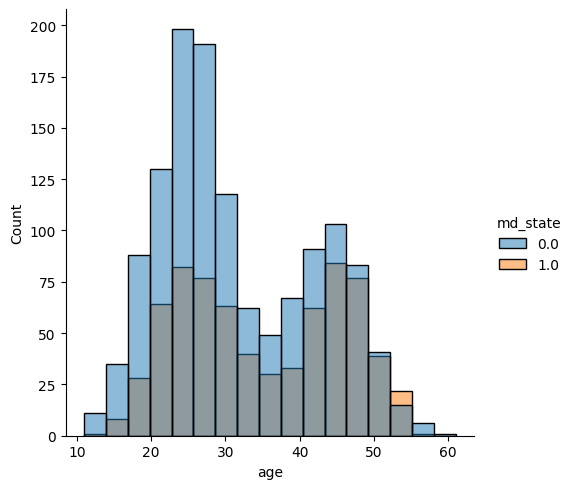

In [11]:
sns.displot(available_data, x='age', hue='md_state')

observably higher proportion of missing state values for older respondents comppared to younger

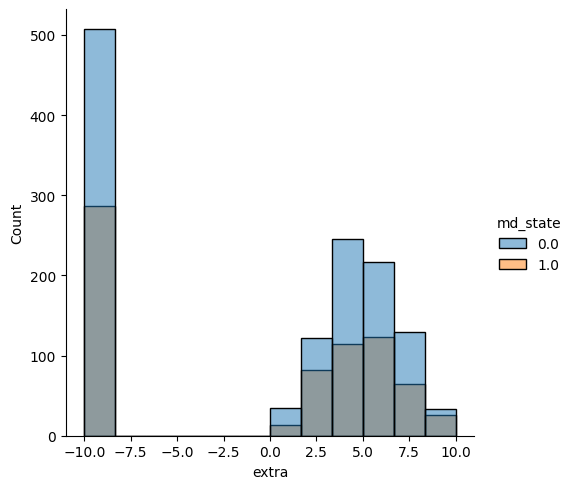

In [12]:
sns.displot(available_data[['extra','md_state']].fillna(-10), x='extra',hue='md_state')

while missing state is not significantly related to extraversion itself, it seems like it is correlated to the missingness of extraversion.  This is enough evidence to imply that this is an MAR pattern.

# Diagnosing MNAR Variables

In [13]:
available_data['md_neuro'] =  available_data['neuro'].isnull().astype(float)
md_neuro_mod = smf.logit('md_neuro~age+open+extra+state+gender+bkg_amt', data=available_data)
md_neuro_mod.fit(disp=0).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               md_neuro   No. Observations:                  726
Model:                          Logit   Df Residuals:                      718
Method:                           MLE   Df Model:                            7
Date:                Mon, 30 Oct 2023   Pseudo R-squ.:                 0.01936
Time:                        14:28:11   Log-Likelihood:                -493.42
converged:                       True   LL-Null:                       -503.16
Covariance Type:            nonrobust   LLR p-value:                  0.006812
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.2564      0.456     -0.562      0.574      -1.150       0.637
state[T.B]      0.0471      0.182      0.259      0.796      -0.309       0.404
state[T.C]     -0.1283      0.188     -0.683      0.495      -0.497       0.240
gender[T.M]     0.0935      0.151      0.618      0.537      -0.203       0.390
age            -0.0126      0.008     -1.552      0.121      -0.029       0.003
open            0.0524      0.039      1.361      0.173      -0.023       0.128
extra          -0.0850      0.041     -2.092      0.036      -0.165      -0.005
bkg_amt         0.0032      0.001      3.020      0.003       0.001       0.005
===============================================================================
"""

missing neuroticism is strongly correlated to extraversion and booking amount.  Based on our causal diagram, booking amount is a child of neuroticism, which would mean that booking amount is not the cause of the missingness of neuroticism. 

This can be confirmed by identifying another child of the missing data that is ideally uncorrelated with the first, highly correlated value.

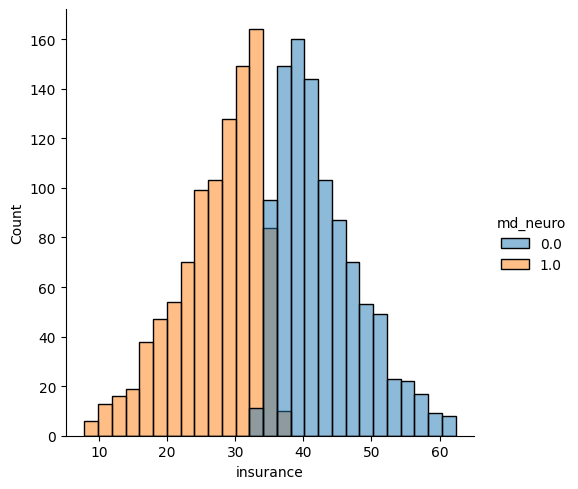

In [14]:
supplement = pd.read_csv(r'/home/beastman/Projects/HomeSchool/data-analysis/BehavioralDataAnalysis/Chapter 6 - Handling missing data/chap6-available_data_supp.csv')

complete_data = pd.merge(left=supplement,right=available_data,left_index=True, right_index=True)

sns.displot(complete_data, x='insurance', hue='md_neuro')

## Handling Missing Data

In [52]:
from sklearn.preprocessing import OneHotEncoder

# not really a fan of how it was done in the book but jesus this was annoying
# mans really hid a bunch of code in the notebooks NOT in the book itself
# sklearn does not allow you to encode rows with null, but creates a feature for null instead
# use pandas where to fill features in that family instead where the null rows are true
# have to do this just because sklearn can't handle categoricals very well or something

ohc = OneHotEncoder(handle_unknown='ignore',sparse_output=False)

hot_data = ohc.fit_transform(available_data.select_dtypes('object'))

labels = list(ohc.get_feature_names_out())

comb = pd.DataFrame(columns=labels, data=hot_data)

comb_null = comb.iloc[:,2:5].where(comb.state_nan == 0.0)

hot_df = pd.concat([comb_null, comb[["gender_F", "gender_M"]]],axis=1)
encoded_data = pd.concat([available_data.copy().drop(["state", "gender", "md_extra", "md_state", "md_neuro"],axis=1), hot_df],axis=1)

,gender_F,gender_M,state_A,state_B,state_C,state_nan
0,1.0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0
2,1.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...
1995,0.0,1.0,1.0,0.0,0.0,0.0
1996,0.0,1.0,0.0,0.0,0.0,1.0
1997,0.0,1.0,0.0,0.0,1.0,0.0
1998,0.0,1.0,1.0,0.0,0.0,0.0


In [66]:
MI_data_df = mice.MICEData(encoded_data)
fit = mice.MICE(model_formula='bkg_amt~age+open+extra+neuro+gender_F+gender_M+state_A+state_B+state_C', model_class=sm.OLS, data=MI_data_df)
MI_summ = fit.fit().summary()
MI_summ

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: MICE
===================================================================
Method:                  MICE         Sample size:          2000   
Model:                   OLS          Scale                 5012.51
Dependent variable:      bkg_amt      Num. imputations      10     
-------------------------------------------------------------------
           Coef.   Std.Err.    t    P>|t|   [0.025   0.975]   FMI  
-------------------------------------------------------------------
Intercept 121.6139   8.6451 14.0673 0.0000 104.6698 138.5581 0.4465
age        -1.0930   0.1819 -6.0096 0.0000  -1.4494  -0.7365 0.3414
open        2.9976   0.8657  3.4628 0.0005   1.3010   4.6943 0.1214
extra      11.0606   0.9986 11.0766 0.0000   9.1035  13.0177 0.3552
neuro      -4.9858   2.1035 -2.3702 0.0178  -9.1086  -0.8630 0.5795
gender_F   55.0603   4.5715 12.0443 0.0000  46.1004  64.0203 0.3875
gender_M   66.5536   4.7561 13.9932 0.0000  57.2317  75.8754 0.4287
state_A    41.5284   3.2773 12.6716 0.0000  35.1051  47.9518 0.1449
state_B    37.6203   4.3453  8.6576 0.0000  29.1036  46.1370 0.3810
state_C    42.4652   4.1920 10.1302 0.0000  34.2491  50.6813 0.3407
===================================================================

"""